# Methodenseminar Zeitreihenvorhersage mit RNNs

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import yfinance

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

<img src="pics/cross.png">

## Beispiel: UBS Aktie

In [3]:
yahoo_UBS = yfinance.Ticker("UBS")
UBS = yahoo_UBS.history(period="5y")
UBS

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-11-18,13.262122,13.337359,13.210140,13.330519,1217400,0.0,0
2015-11-19,13.439956,13.501513,13.412598,13.480993,973300,0.0,0
2015-11-20,13.480992,13.501512,13.299741,13.323680,1041700,0.0,0
2015-11-23,13.180048,13.205354,13.077453,13.125331,1202400,0.0,0
2015-11-24,13.063775,13.166369,13.043255,13.132172,1105400,0.0,0
...,...,...,...,...,...,...,...
2020-11-12,13.530000,13.590000,13.385000,13.470000,1979200,0.0,0
2020-11-13,13.600000,13.690000,13.595000,13.670000,2284600,0.0,0
2020-11-16,14.050000,14.335000,14.040000,14.260000,5037600,0.0,0


### Datensatz definieren

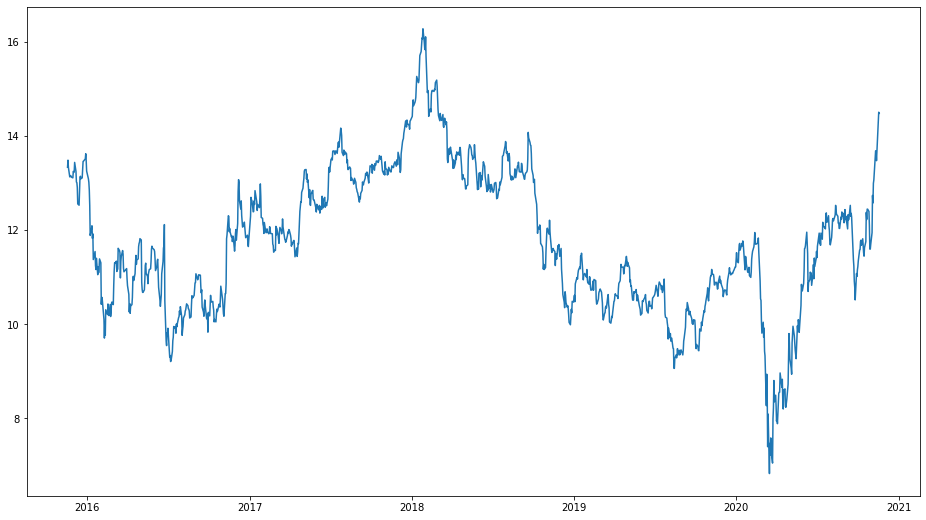

In [4]:
UBS_close =UBS["Close"]
plt.figure(figsize=(16,9))
plt.plot(UBS_close)

### In ein supervised Problem übersetzen

In [5]:
n_steps = 50

prediction_set = UBS_close[-n_steps-3:]

X, y = split_sequence(UBS_close[:-n_steps-3], n_steps)

# number of samples
print('Samples: %d' % len(X))

# print first 5 samples
for i in range(5):
    print('%s => %s' % (X[i],y[i]))

Samples: 1157
[13.33051872 13.48099327 13.32367992 13.12533092 13.13217163 13.15268993
 13.11849308 13.10481167 13.24160576 13.22108555 13.22792721 13.43311691
 13.24160576 13.0158968  13.00221729 12.89962196 12.55079842 12.52343845
 12.78334713 13.10481167 13.13900852 13.0842905  13.10481167 13.26212502
 13.45363331 13.46047497 13.50835323 13.61778831 13.47415352 13.24844551
 13.0842905  13.009058   12.8449049  12.51660061 11.88051033 12.02414322
 12.08570004 11.81895256 11.91470718 11.36753654 11.53852749 11.23758221
 11.15550423 11.39489269 11.04606915 11.2102232  11.0871067  11.17602444
 11.38121319 11.29913807] => 10.416820526123047
[13.48099327 13.32367992 13.12533092 13.13217163 13.15268993 13.11849308
 13.10481167 13.24160576 13.22108555 13.22792721 13.43311691 13.24160576
 13.0158968  13.00221729 12.89962196 12.55079842 12.52343845 12.78334713
 13.10481167 13.13900852 13.0842905  13.10481167 13.26212502 13.45363331
 13.46047497 13.50835323 13.61778831 13.47415352 13.24844551 1

In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13, shuffle = True)

# min max scaling
# konvergiert schneller, training ist stabiler und führt zu besseren Vorhersagen
max_value = X_train.max()
min_value = X_train.min()

X_test_scaled = (X_test - min_value)/(max_value - min_value)
X_train_scaled = (X_train - min_value)/(max_value- min_value)

#reshape data to make keras happy
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape(y_train.shape[0],1)
y_test = y_test.reshape(y_test.shape[0],1)

### Modell erstellen und trainieren

In [7]:
# define model
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', input_shape=(n_steps, 1)))
model.add(Dense(units = 1))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [8]:
hist = model.fit(X_train_scaled, y_train, epochs=500, validation_data=(X_test_scaled, y_test))

Epoch 1/500
25/25 [==============================] - 1s 29ms/step - loss: 134.5541 - val_loss: 122.2601
Epoch 2/500
25/25 [==============================] - 0s 20ms/step - loss: 124.6026 - val_loss: 123.9278
Epoch 3/500
25/25 [==============================] - 0s 19ms/step - loss: 124.5951 - val_loss: 122.7380
Epoch 4/500
25/25 [==============================] - 0s 18ms/step - loss: 122.3346 - val_loss: 118.5083
Epoch 5/500
25/25 [==============================] - 0s 20ms/step - loss: 104.2164 - val_loss: 86.6797
Epoch 6/500
25/25 [==============================] - 0s 19ms/step - loss: 45.3298 - val_loss: 1.7832
Epoch 7/500
25/25 [==============================] - 0s 18ms/step - loss: 2.4471 - val_loss: 1.2122
Epoch 8/500
25/25 [==============================] - 0s 19ms/step - loss: 1.0481 - val_loss: 0.6386
Epoch 9/500
25/25 [==============================] - 0s 18ms/step - loss: 0.8284 - val_loss: 1.1168
Epoch 10/500
25/25 [==============================] - 0s 19ms/step - loss: 0.810

25/25 [==============================] - 0s 19ms/step - loss: 0.2149 - val_loss: 0.2510
Epoch 83/500
25/25 [==============================] - 0s 19ms/step - loss: 0.2107 - val_loss: 0.1743
Epoch 84/500
25/25 [==============================] - 0s 19ms/step - loss: 0.1928 - val_loss: 0.1583
Epoch 85/500
25/25 [==============================] - 0s 18ms/step - loss: 0.2355 - val_loss: 0.2822
Epoch 86/500
25/25 [==============================] - 0s 19ms/step - loss: 0.1942 - val_loss: 0.1504
Epoch 87/500
25/25 [==============================] - 0s 19ms/step - loss: 0.1772 - val_loss: 0.2199
Epoch 88/500
25/25 [==============================] - 0s 19ms/step - loss: 0.1964 - val_loss: 0.1632
Epoch 89/500
25/25 [==============================] - 0s 19ms/step - loss: 0.1696 - val_loss: 0.3259
Epoch 90/500
25/25 [==============================] - 0s 19ms/step - loss: 0.2207 - val_loss: 0.1669
Epoch 91/500
25/25 [==============================] - 0s 19ms/step - loss: 0.2204 - val_loss: 0.1529
Epo

25/25 [==============================] - 0s 19ms/step - loss: 0.0631 - val_loss: 0.0609
Epoch 243/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0565 - val_loss: 0.0652
Epoch 244/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0780 - val_loss: 0.0823
Epoch 245/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0845 - val_loss: 0.0817
Epoch 246/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0586 - val_loss: 0.0605
Epoch 247/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0573 - val_loss: 0.0651
Epoch 248/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0682 - val_loss: 0.0564
Epoch 249/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0642 - val_loss: 0.1179
Epoch 250/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0648 - val_loss: 0.0571
Epoch 251/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0517 - val_loss: 0

25/25 [==============================] - 0s 19ms/step - loss: 0.0576 - val_loss: 0.0553
Epoch 403/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0462 - val_loss: 0.0743
Epoch 404/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0507 - val_loss: 0.0623
Epoch 405/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0490 - val_loss: 0.0553
Epoch 406/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0570 - val_loss: 0.0631
Epoch 407/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0490 - val_loss: 0.0515
Epoch 408/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0510 - val_loss: 0.0641
Epoch 409/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0617 - val_loss: 0.0537
Epoch 410/500
25/25 [==============================] - 0s 18ms/step - loss: 0.0535 - val_loss: 0.0507
Epoch 411/500
25/25 [==============================] - 0s 19ms/step - loss: 0.0468 - val_loss: 0

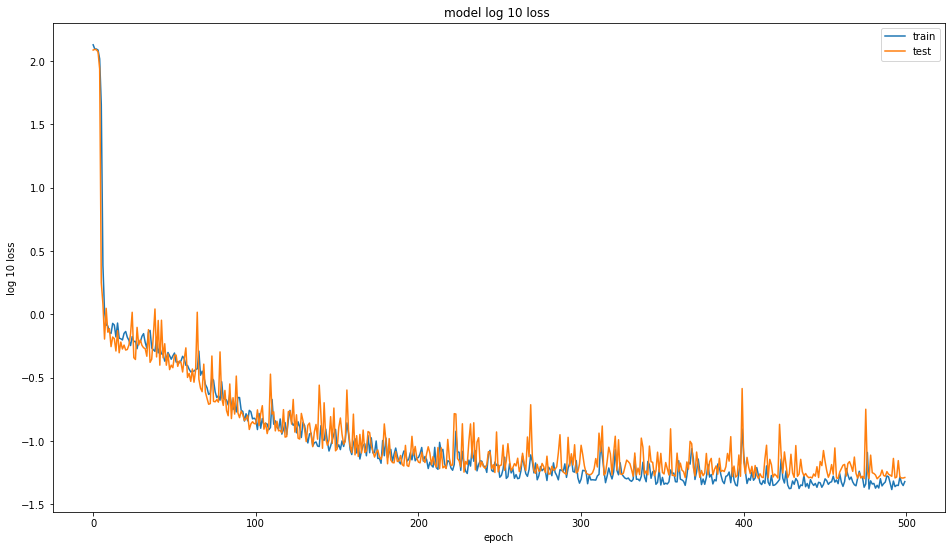

In [9]:
plt.figure(figsize=(16,9))
plt.plot(np.log10(hist.history['loss']))
plt.plot(np.log10(hist.history['val_loss']))
plt.title('model log 10 loss ')
plt.ylabel('log 10 loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')    

### Vorhersage erstellen

In [10]:
X_predict_, y_predict_ = split_sequence(prediction_set, n_steps)

X_predict = (X_predict_ - min_value)/(max_value - min_value)
X_predict = X_predict.reshape((X_predict.shape[0], X_predict.shape[1], 1))

prediction = model.predict(X_predict)


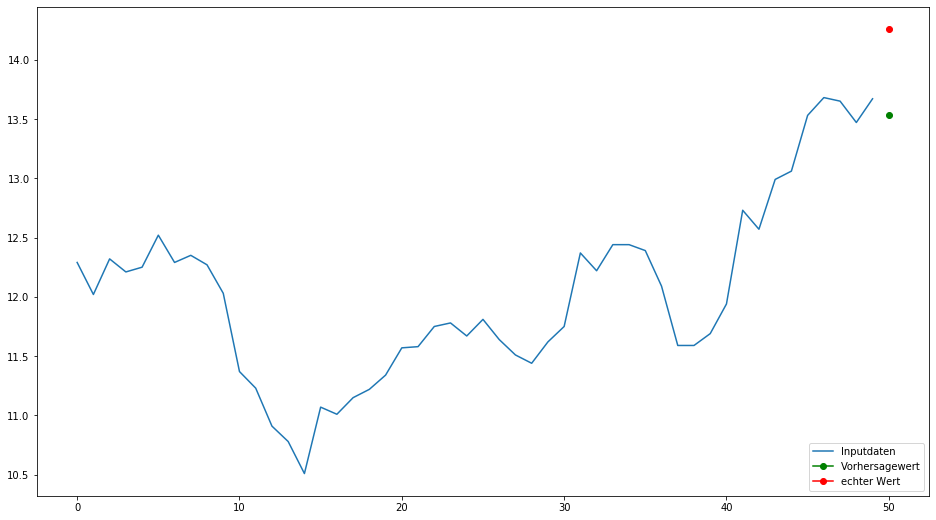

In [11]:
plt.figure(figsize=(16,9))
plt.plot(X_predict_[0])
plt.plot(50, prediction[0], marker="o", color = "green")
plt.plot(50, y_predict_[0], marker="o", color = "red")
plt.legend(['Inputdaten', 'Vorhersagewert', "echter Wert"], loc='lower right')    

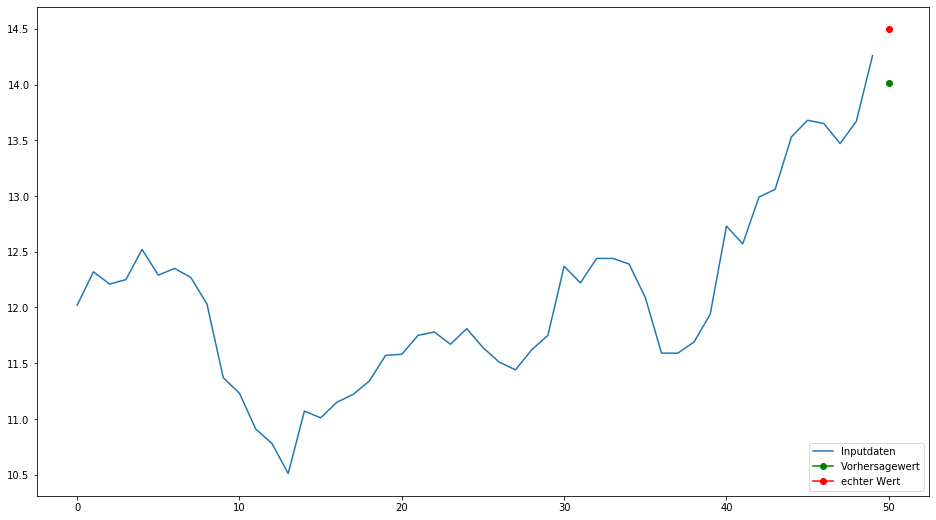

In [12]:
plt.figure(figsize=(16,9))
plt.plot(X_predict_[1])
plt.plot(50, prediction[1], marker="o", color = "green")
plt.plot(50, y_predict_[1], marker="o", color = "red")
plt.legend(['Inputdaten', 'Vorhersagewert', "echter Wert"], loc='lower right')    

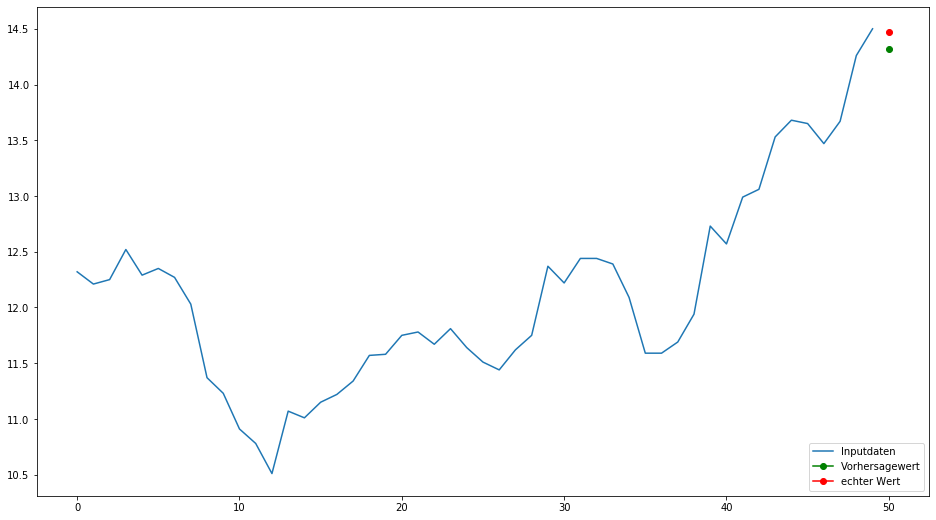

In [13]:
plt.figure(figsize=(16,9))
plt.plot(X_predict_[2])
plt.plot(50, prediction[2], marker="o", color = "green")
plt.plot(50, y_predict_[2], marker="o", color = "red")
plt.legend(['Inputdaten', 'Vorhersagewert', "echter Wert"], loc='lower right')    

### Modell Evaluation

In [14]:
df_test = pd.DataFrame(X_test)
df_train = pd.DataFrame(X_train)
df_test

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,14.326365,14.373109,14.232883,14.295205,14.116029,13.508385,13.430482,13.726515,13.609659,13.703143,...,13.809832,13.750671,13.691511,13.590091,13.581639,13.497125,13.547834,13.809832,13.649252,13.497125
1,13.485013,13.282466,13.282466,13.336999,13.321419,13.305838,13.048757,13.111079,13.056548,13.048757,...,13.375949,13.329208,13.266886,13.407110,13.368160,13.383740,13.461642,13.461642,13.430482,13.446062
2,12.622565,12.381848,12.389370,12.615043,12.539820,12.833190,12.592475,12.411939,12.539820,12.509727,...,11.787580,11.712358,11.945551,12.050864,11.983163,11.915461,11.990685,12.231402,12.065908,11.877850
3,11.953074,11.922984,12.005731,11.998208,11.885371,11.817670,11.652178,11.719878,11.697312,11.772536,...,12.651452,12.635870,12.635870,12.464485,12.378792,12.542387,12.519016,12.425533,12.448903,12.519016
4,7.209972,7.575372,7.272357,7.040640,7.985333,8.208138,8.796344,8.341822,8.484418,8.252700,...,9.360000,9.260000,9.960000,9.840000,10.090000,10.020000,9.820000,10.390000,10.840000,10.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,11.211550,11.211550,11.514566,11.327409,11.300673,11.532390,11.683897,11.710634,11.568038,11.666074,...,10.052964,9.803423,10.035140,9.714301,9.910369,9.420197,9.322165,8.261612,8.930027,8.448767
378,9.473672,9.339988,9.438023,9.339988,9.366725,9.429110,9.446936,9.339988,9.438023,9.634091,...,10.115350,10.284682,10.249032,10.373804,10.418365,10.489662,10.650082,10.765941,10.552048,10.489662
379,11.544816,11.434947,11.603977,11.164497,10.860241,10.623597,10.463018,10.344696,10.682758,10.606695,...,11.156045,10.953209,10.877144,10.843338,11.003918,10.978562,10.792629,10.716564,10.725016,10.834887
380,11.812114,11.784754,10.881919,10.731444,10.669888,10.669888,10.724605,10.936637,11.242208,11.291103,...,9.636178,9.538386,9.809192,9.749014,9.906983,9.297670,9.327760,9.199879,9.214925,9.410506


#### Naive Model

In [15]:
from sklearn.metrics import mean_squared_error

mean_squared_error(df_test[49], y_test)

0.046445416836008224

#### Random Forest

In [16]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(df_train, y_train.flatten())
y_pred = regr.predict(X_test)
mean_squared_error(y_pred, y_test)

0.17292854308236688

#### Mögliche Verbesserungen

Daten
- Analyse (Autokorrelation, Saisonalität, Trends, ...)
- Mehr Daten
- Mehr Lag
- Zustätzliche Features (Moving Average, Volume, korrelierende Aktien)
- Nur Veränderungen

Modell
- Learning Rate verkleinern
- Dropout Layer
- Andere Architektur (kleinere, gestackte LSTM Schichten)

Evaluierung
- Residual Analysis
- Ausreisser